# <center>升维嵌入学习算法：求解无粘性 Burgers 方程 </center>
### <center>孙琪，同济大学《偏微分方程数值解》

## 1. 问题描述（Inviscid Burgers Equation）
考虑无粘 Burgers 方程
\begin{equation*}
\left\{\begin{array}{ll}
\partial_tu(x,t)+u(x,t)\partial_xu(x,t)=0,& \mathrm{for}\ (x,t)\in(-1,1)\times(0,1),\\
u(x,0)=2H(-x),& \mathrm{for}\ x\in(-1,1),\\
u(-1,t)=2,\ u(1,t)=0, & \mathrm{for}\ t\in[0,1],
\end{array}\right.
\end{equation*}
其中 $H(x) = 1_{x\geq 0}$ 为分片线性函数。根据 Rankine-Hugoniot 跳量条件, 在激波 $\Gamma=\big\{(x(t),t)\,|\,x(t)=st\big\}$ 处满足关系式
$$
s=\frac{【 f(u)】}{【 u 】}=\frac{1}{2}\left(u^+(x,t)+u^-(x,t)\right)\Big|_\Gamma=1\ \ \Rightarrow \ \ u(x, t) = \left\{
    \begin{array}{ll}
    2, \ \ & x < t, \\
    0, \ \ & x \geq t.
    \end{array}\right.
$$
其中 $f(u)=\frac{1}{2}u^2$，符号【】表示左右极限之差，且除此之外解的函数值沿着特征线保持不变。

<center><img src="figures//fig-CharLines-Burgers-1Shock.jpg" width="250"></center>


## 2. 升维嵌入学习方法
通过引入辅助变量 $\varphi(x,t) =  H(x - st)$（其中 $s=1$ 为未知条件），考虑如下形式的方程解
\begin{equation*}
	u(x,t) = \hat{u}(x,t,\varphi(x,t))
\end{equation*}
并将其带入方程并结合 Rankine-Hugoniot 跳量条件，可以推导得出
\begin{equation*}
	\left\{
	\begin{array}{ll}
		\partial_t \hat{u}(x,t,\varphi(x,t)) + \hat{u}(x,t,\varphi(x,t)) \partial_x \hat{u}(x,t,\varphi(x,t)) = 0, \ \ & \textnormal{for}\ (x,t)\in (-1,1)\times (0,1)\setminus \Gamma,\\
		\frac12 ( \hat{u}(x,t,\varphi^+(x,t)) + \hat{u}(x,t,\varphi^-(x,t)) ) = s ,  \ \ & \textnormal{for}\ (x,t)\in \Gamma,\\
		\hat{u}(x,0,\varphi(x,0)) = u_0(x), \ \ & \textnormal{for}\ x\in (-1,1), \\
		\hat{u}(-1,t,\varphi(-1,t)) = 2,\  \hat{u}(1, t, \varphi(1, t)) = 0,\ \  & \textnormal{for}\ t\in [0,1].
	\end{array}\right.
\end{equation*}


#### 函数逼近

由于辅助变量的引入导致函数自变量维数的升高，因此需采用无惧“维数灾难”的函数逼近工具，即人工神经网络

- 通用逼近性质：任意复杂的函数都可以通过一个适当的人工神经网络来表示或逼近

在此，我们使用一个全连接网络（fully-connected neural network）来参数化未知函数，其中神经网络的待定参数用 $\theta$ 表示，即

$$
\hat{u}(x,t,\varphi) \approx  \hat{u}_{\mathrm{NN}}(x,t,\varphi;\theta).
$$

#### 损失函数

通过方程的残量来定义方程解在光滑、间断、边界以及初值处的损失函数

\begin{equation*}
	\begin{array}{c}
		\displaystyle L_{\textnormal{Intrr}} (\hat{u}_{\mathrm{NN}}) = \frac{1}{N_{\textnormal{Intrr}}} \sum_{n=1}^{N_{\textnormal{Intrr}}} \big| \partial_t\hat{u}_{\mathrm{NN}}(x_n,t_n, \varphi(x_n, t_n); \theta) - \partial_x \hat{u}_{\mathrm{NN}}(x_n,t_n, \varphi(x_n, t_n); \theta) \big|^2,\\
		\displaystyle L_{\textnormal{Shock}} (\hat{u}_{\mathrm{NN}}, s) = \frac{1}{N_{\textnormal{Shock}}} \sum_{n=1}^{N_{\textnormal{Shock}}} \big| \frac12 \left( \hat{u}^+_{\mathrm{NN}}(x_n,t_n,\varphi(x_n,t_n)) + \hat{u}^-_{\mathrm{NN}}(x_n,t_n,\varphi(x_n,t_n)) \right) - s \big|^2, \\
		\displaystyle L_{\textnormal{Bndry}} (\hat{u}_{\mathrm{NN}}) = \frac{1}{N_{\textnormal{Bndry}}} \sum_{n=1}^{N_{\textnormal{Bndry}}} \big|  \hat{u}_{\mathrm{NN}}(-1, t_n, \varphi(-1, t_n); \theta) - \hat{u}_{\mathrm{NN}}(1, t_n, \varphi(1, t_n); \theta) \big|^2, \\ 
		\displaystyle L_{\textnormal{Initl}} (\hat{u}_{\mathrm{NN}}) = \frac{1}{N_{\textnormal{Initl}}} \sum_{n=1}^{N_{\textnormal{Initl}}} \big|  \hat{u}_{\mathrm{NN}}(x_n, 0, \varphi(x_n, 0); \theta) - u_0(x_n) \big|^2,
	\end{array}
\end{equation*}

进而求解以下优化问题来近似得到神经网络的最优参数

\begin{equation*}
	\theta^*, s^* = \operatorname*{arg\, min}_{\theta, s} ~~ L_{\textnormal{Intrr}} (\hat{u}_{\mathrm{NN}}) + \beta_{\textnormal{S}} L_{\textnormal{Shock}} (\hat{u}_{\mathrm{NN}}, s) + \beta_{\textnormal{B}} L_{\textnormal{Bndry}} (\hat{u}_{\mathrm{NN}}) + \beta_{\textnormal{I}} L_{\textnormal{Initl}} (\hat{u}_{\mathrm{NN}})
\end{equation*}
其中 $ \beta_S$、$\beta_B$ 和 $\beta_I$ 为相应的惩罚系数。

#### 自动微分

自动微分技术 **Auto Differentiation**（[`torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd)）可以用来精确计算模型解关于输入变量的导数（即 $\partial_t\hat{u}_{\mathrm{NN}}$、$\partial_x\hat{u}_{\mathrm{NN}}$），进而用于构造损失函数。

<center><img src="figures//PINNs-flowchart.jpg" width="500"></center>

## 3. 编程求解

#### 3-1. 准备工作 - 调用函数库

In [1]:
import torch
print("torch version =", torch.__version__)
import torch.nn as nn
import numpy as np
import os
import time
import datetime
import argparse
import scipy.io as io
import math
import shutil
from torch import optim, autograd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from itertools import cycle

torch version = 2.4.0


#### 3-1. 准备工作 - 全连接神经网络

In [2]:
class FcBlock(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of each block's output data (not the dimension of final output)  
    """
    
    def __init__(self, dim_in, width, dim_out):
        super(FcBlock, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out

        # create linear layers
        self.Linear1 = nn.Linear(dim_in, width)
        self.Linear2 = nn.Linear(width, dim_out)  
        # choose activation function = Tanh
        self.activation = nn.Tanh()      

    def forward(self, x):
        
        return self.activation(self.Linear2(self.activation(self.Linear1(x))))


class FcNet(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of final output data   
    """

    def __init__(self, dim_in, width, dim_out, depth):
        super(FcNet, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out
        self.depth = depth

        # creat a list for holding all blocks/layers
        self.stack = nn.ModuleList()
                
        # input layer       
        self.stack.append(nn.Linear(dim_in, width))
        # add hidden blocks
        for i in range(depth):
            self.stack.append(FcBlock(width, width, width))        
        # output layer
        self.stack.append(nn.Linear(width, dim_out))  
        
    def forward(self, x):
        
        for layer in self.stack:
            x = layer(x)

        return x   

    def Xavier_initi(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()    

#### 3-1. 准备工作 - 训练和测试数据集

In [3]:
# computational domain
x_min, x_max = -1, 1
t_min, t_max = 0, 1

# number of collocation points for each part
traindata_size_intrr = 20000
traindata_size_initl = 501
traindata_size_bndry = 501
traindata_size_shock = 501

# generate testing points over the entire domain
x = torch.linspace(x_min, x_max, traindata_size_initl)
t = torch.linspace(t_min, t_max, traindata_size_bndry)
X, T = torch.meshgrid(x,t,indexing="ij") 
testdata = torch.squeeze(torch.stack([X.reshape(1,traindata_size_initl*traindata_size_bndry), T.reshape(1,traindata_size_initl*traindata_size_bndry)], dim=-1))   

# generate training points for each part
def SmpPts_Interior(num_intrr_pts):    
    """ num_intrr_pts = total number of sampling points inside the domain
        dim_prob  = dimension of sampling domain """
    
    # domain (-1,1) * (0,1)                
    X_intrr = torch.rand(num_intrr_pts * 2, 1) * 2 - 1 
    T_intrr = torch.rand(num_intrr_pts * 2, 1)
    XT_intrr = torch.cat([X_intrr, T_intrr], dim=1)
    
    return XT_intrr

def SmpPts_Initial(num_initl_pts):
    ''' num_initl_pts = total number of sampling points at initial time'''
    
    T_initl = torch.zeros(num_initl_pts, 1)
    XT_initl = torch.cat([torch.rand(num_initl_pts, 1) * 2 -1, T_initl], dim=1)
    
    return XT_initl

def SmpPts_Boundary(num_bndry_pts):
    ''' num_bndry_pts = number of sampling points for each boundary'''

    T_bndrL = - torch.ones(num_bndry_pts, 1)
    T_bndrR = torch.ones(num_bndry_pts, 1)

    XT_bndrL = torch.cat([T_bndrL, torch.rand(num_bndry_pts, 1)], dim = 1)
    XT_bndrR = torch.cat([T_bndrR, torch.rand(num_bndry_pts, 1)], dim = 1)

    return XT_bndrL, XT_bndrR

def SmpPts_Shock(num_shock_pts, shock_speed):
    ''' num_shock_pts = number of sampling points for shock curve'''
    
    T_shock = torch.rand(num_shock_pts, 1)
    X_shock = shock_speed * T_shock
    XT_shock = torch.cat([X_shock, T_shock], dim=1)
    
    return XT_shock

smppts_intrr = SmpPts_Interior(traindata_size_intrr)
smppts_bndrL, smppts_bndrR = SmpPts_Boundary(traindata_size_bndry)
smppts_initl = SmpPts_Initial(traindata_size_initl)

#### 3-1. 准备工作 - 定义升维函数

In [4]:
# define auxiliary variable using modified Heaviside function 
def augmented_variable(x, t, shock_speed):
    '''  set a custom value 1 at the origin for Heaviside function '''
    
    temp = torch.ones(x.size(0))
    value = torch.heaviside(x - shock_speed * t, torch.squeeze(temp))
    
    return value

# initial value and exact solution
def u_Exact_Initial(x):
    
    u0 = torch.zeros(x.size(0))
    mask = x < 0
    u0[mask]= 2
    
    return u0

def u_Exact_Solution(x, t):
    
    return u_Exact_Initial(x - t)

#### 3-2. 网络训练

Done in 0:03:28.533028 !


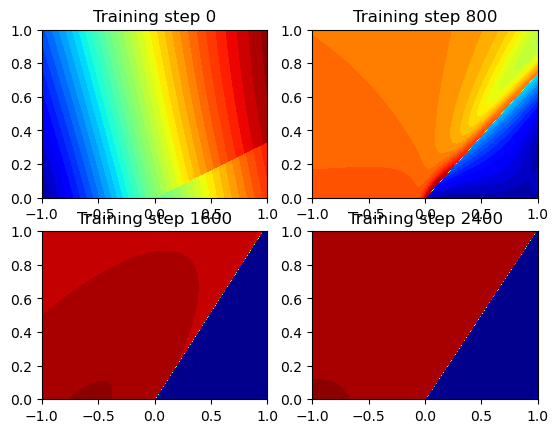

In [5]:
# penalty coefficient
beta = 400
# for decay of learning rate
milestones = [1500, 2100, 2400]

model = FcNet(3, 40, 1,3)
model.Xavier_initi()

# initial guess of shock speed, true value is 1 for this example
shock_speed_parameter = torch.nn.Parameter(3 * torch.ones(1, requires_grad=True))
hist_shock_speed = []

# create optimizer and learning rate schedular
optimizer = torch.optim.AdamW(list(model.parameters())+[shock_speed_parameter], lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

since = time.time()
for i in range(3001):

    # save the value of shock speed at current iteration
    hist_shock_speed.append(shock_speed_parameter.item())

    shock_speed = torch.squeeze(shock_speed_parameter.detach())
    # update collocation points along shock curve
    smppts_shock = SmpPts_Shock(traindata_size_shock, shock_speed)
    
    # append the value of auxiliary variable for each input data point
    smppts_intrr_updated = torch.cat([smppts_intrr, augmented_variable(smppts_intrr[:,0], smppts_intrr[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_bndrL_updated = torch.cat([smppts_bndrL, augmented_variable(smppts_bndrL[:,0], smppts_bndrL[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_bndrR_updated = torch.cat([smppts_bndrR, augmented_variable(smppts_bndrR[:,0], smppts_bndrR[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_initl_updated = torch.cat([smppts_initl, augmented_variable(smppts_initl[:,0], smppts_initl[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_test_updated = torch.cat([testdata, augmented_variable(testdata[:,0], testdata[:,1], shock_speed).reshape(-1,1)], dim=1)
    # in particular, use mp0.0001 to achieve left and right limits along shock curve
    smppts_shckL_updated = torch.cat([smppts_shock, augmented_variable(smppts_shock[:,0] - 0.0001, smppts_shock[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_shckR_updated = torch.cat([smppts_shock, augmented_variable(smppts_shock[:,0] + 0.0001, smppts_shock[:,1], shock_speed).reshape(-1,1)], dim=1)

    # enable computing gradients through autograd
    smppts_intrr_updated.requires_grad = True 

    # compute values of initial condition
    u0_smppts = u_Exact_Initial(smppts_initl_updated[:, 0])
    
    u_NN_intrr = model(smppts_intrr_updated)
    u_NN_bndrL = model(smppts_bndrL_updated)
    u_NN_bndrR = model(smppts_bndrR_updated)
    u_NN_initl = model(smppts_initl_updated)

    u_NN_shckL = model(smppts_shckL_updated)
    u_NN_shckR = model(smppts_shckR_updated) 

    # zero parameter gradients and then compute NN prediction of gradient u(x)
    model.zero_grad()
    gradu_NN_intrr = torch.autograd.grad(outputs=u_NN_intrr, inputs=smppts_intrr_updated, grad_outputs=torch.ones_like(u_NN_intrr), retain_graph=True, create_graph=True, only_inputs=True)[0]

    # construct mini-batch loss function and then perform backward pass
    loss_intrr = torch.mean(torch.pow(gradu_NN_intrr[:,1] + torch.squeeze(u_NN_intrr) * gradu_NN_intrr[:,0], 2))
    loss_bndry = torch.mean(torch.pow(u_NN_bndrL - 2, 2)) + torch.mean(torch.pow(u_NN_bndrR, 2))
    loss_initl = torch.mean(torch.pow(torch.squeeze(u_NN_initl) - u0_smppts, 2))
    loss_shock = torch.mean(torch.pow(torch.squeeze(u_NN_shckR + u_NN_shckL) * 0.5 - shock_speed_parameter, 2))

    loss_minibatch = loss_intrr + loss_bndry + beta * (loss_initl + loss_shock)

    #zero parameter gradients
    optimizer.zero_grad()
    # backpropagation
    loss_minibatch.backward()
    # network parameter update
    optimizer.step()

    # plot the result as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if i % 800 == 0: 
        ax = plt.subplot(2, 2, i // 800 + 1)
        
        u_test = model(smppts_test_updated).detach()
        u_test = u_test.reshape(traindata_size_initl, traindata_size_bndry)    

        ax.contourf(X, T, u_test, 40, cmap = 'jet')        
        ax.set_title(f"Training step {i}")
        
        list_of_plots.append(ax)
    
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

#### 3-3. 展示计算结果

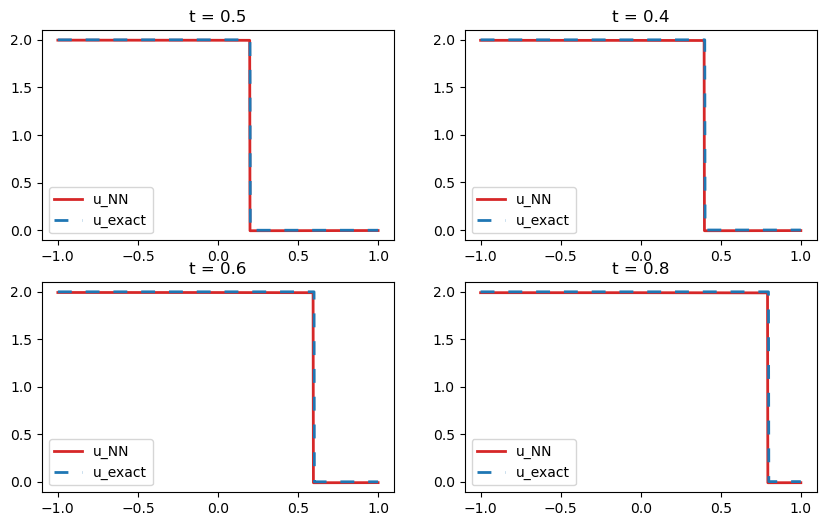

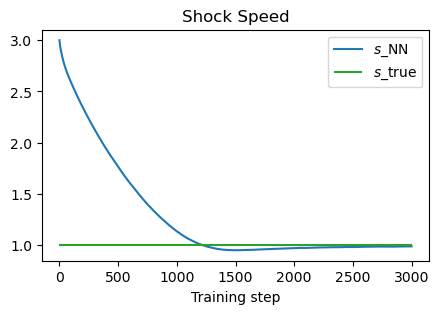

In [6]:
x = torch.linspace(x_min, x_max, steps = 1001)
t = torch.ones(x.size())

# plot the solution at t = 0.2
u_exact = u_Exact_Solution(x, 0.2 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.2 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(2, 2, 1)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.5')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.4
u_exact = u_Exact_Solution(x, 0.4 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.4 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 2)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.4')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.6
u_exact = u_Exact_Solution(x, 0.6 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.6 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 3)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.6')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.8
u_exact = u_Exact_Solution(x, 0.8 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.8 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 4)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.8')
plt.legend(loc = 'lower left')

fig = plt.figure(figsize=(5, 3), dpi= 100)
plt.title(r"Shock Speed")
plt.plot(hist_shock_speed, label=r"$s$_NN")
plt.hlines(1, 0, len(hist_shock_speed), label=r"$s$_true", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## 4. 课后作业（附加题）（Lighthill-Whitham-Richards Model）
考虑连续 LWR 模型的 Cauchy 初值问题
\begin{equation*}
\begin{array}{cl}
\partial_t \rho(x,t)+ \partial_x \left( \rho(x,t) - \rho^2(x,t) \right) = 0, & \mathrm{for}\ x\in\mathbb{R},\ t>0 ,\\
\rho(x,0) = \rho_0(x), & \mathrm{for}\ x\in\mathbb{R},
\end{array}
\end{equation*}
其中 $0\leq \rho(x,t) \leq \rho_{\textnormal{max}} = 1$ 代表车流密度。用机器学习方法分别求解

1) 遇到交通堵塞（traffic jam）后的车流密度演化，其中初值条件取
\begin{equation*}
\rho_0(x) = 
\left\{\begin{array}{ll}
0.5,& \mathrm{for}\ x<0,\\
1,& \mathrm{for}\ x>0.\\
\end{array}\right.
\end{equation*}
2) 遇到绿灯放行（green light）后的车流密度演化，其中初值条件取
\begin{equation*}
\rho_0(x) = 
\left\{\begin{array}{ll}
1,& \mathrm{for}\ x<0,\\
0.5,& \mathrm{for}\ x>0.\\
\end{array}\right.
\end{equation*}

【参考资料】https://faculty.washington.edu/rjl/riemann_book/Traffic_flow.html